In [1]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt


In [3]:

from mtr.config import cfg, cfg_from_yaml_file
from tools.mtr_lightning import MTR_Lightning
from mtr.datasets.waymo.waymo_dataset_bc import WaymoDatasetBC
# from tools.mtr_inference import MTRInference
# import numpy as np
# import matplotlib.pyplot as plt
# from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical, Independent

cfg = cfg_from_yaml_file('../tools/cfgs/waymo/heatmap_bc+10_percent_data.yaml', cfg)
dataset = WaymoDatasetBC(cfg.DATA_CONFIG, training=True)
print(len(dataset))

model = MTR_Lightning(cfg)
model.to('cuda:0')
# ckpt_path = '/home/kai/Desktop/mtr/output/heatmap_bc_atten_2_freeze/epoch=38-step=119028.ckpt'
ckpt_path = '/home/kai/Desktop/mtr/output/heatmap_bc_atten_2_freeze_tar2/epoch=40-step=125132.ckpt'

model = model.load_from_checkpoint(ckpt_path, map_location='cuda:0')
model = model.eval()

model.model.motion_decoder.debug = True

48821


# Test with dataset

```python
# for BC dataset
data = dataset[index]
data_batch = dataset.collate_batch([data])

# for original dataset
scene_id, info = dataset.load_info(index)
data = dataset.extract_scene_data(scene_id, info, shift=0)
data_batch = dataset.collate_batch([data])
```

In [4]:
index = 200

data = dataset[index]
# print(data.keys())
data_batch = dataset.collate_batch([data])
center_gt = data_batch['input_dict']['center_gt'].cpu().numpy()
n_center_objs = center_gt.shape[0]


In [5]:
model.model.motion_decoder.loss_gaussian_std = 2.0

loss, op_dict, _ = model(data_batch, get_loss=True)
print(loss)
print(op_dict.keys())

state_nxt = op_dict['state_nxt']
targets = op_dict['heatmap']
pred_probs = op_dict['layer1_pred_probs']
loss_all = op_dict['layer1_loss_all']

# print(center_gt.shape)
# print(targets.shape)
# print(state_nxt.shape)
# print(pred_probs.shape)

tensor(0.0211, device='cuda:0', grad_fn=<DivBackward0>)
dict_keys(['state_nxt', 'heatmap', 'best_idx_tuple', 'layer0_loss', 'layer0_pred_probs', 'layer0_loss_all', 'layer1_loss', 'layer1_pred_probs', 'layer1_loss_all', 'layer2_loss', 'layer2_pred_probs', 'layer2_loss_all', 'loss_total'])


In [18]:
print(type(model.model))
data_batch = model.model.context_encoder(data_batch)
model.model.motion_decoder.sample(data_batch)

<class 'mtr.models.model.MotionTransformer'>


array([[ 6.4405727e-01, -2.7422078e-02, -8.5102089e-02],
       [ 1.0089275e+00,  7.4774762e-18,  1.4822622e-17],
       [ 1.4039000e+00,  1.5468329e-17,  2.2036222e-17],
       [ 1.2302089e+00,  1.1841123e-17,  1.9250591e-17]], dtype=float32)

6.0118937 0.0
1.7428737 0.0
1.961837 0.0
4.288822 0.0


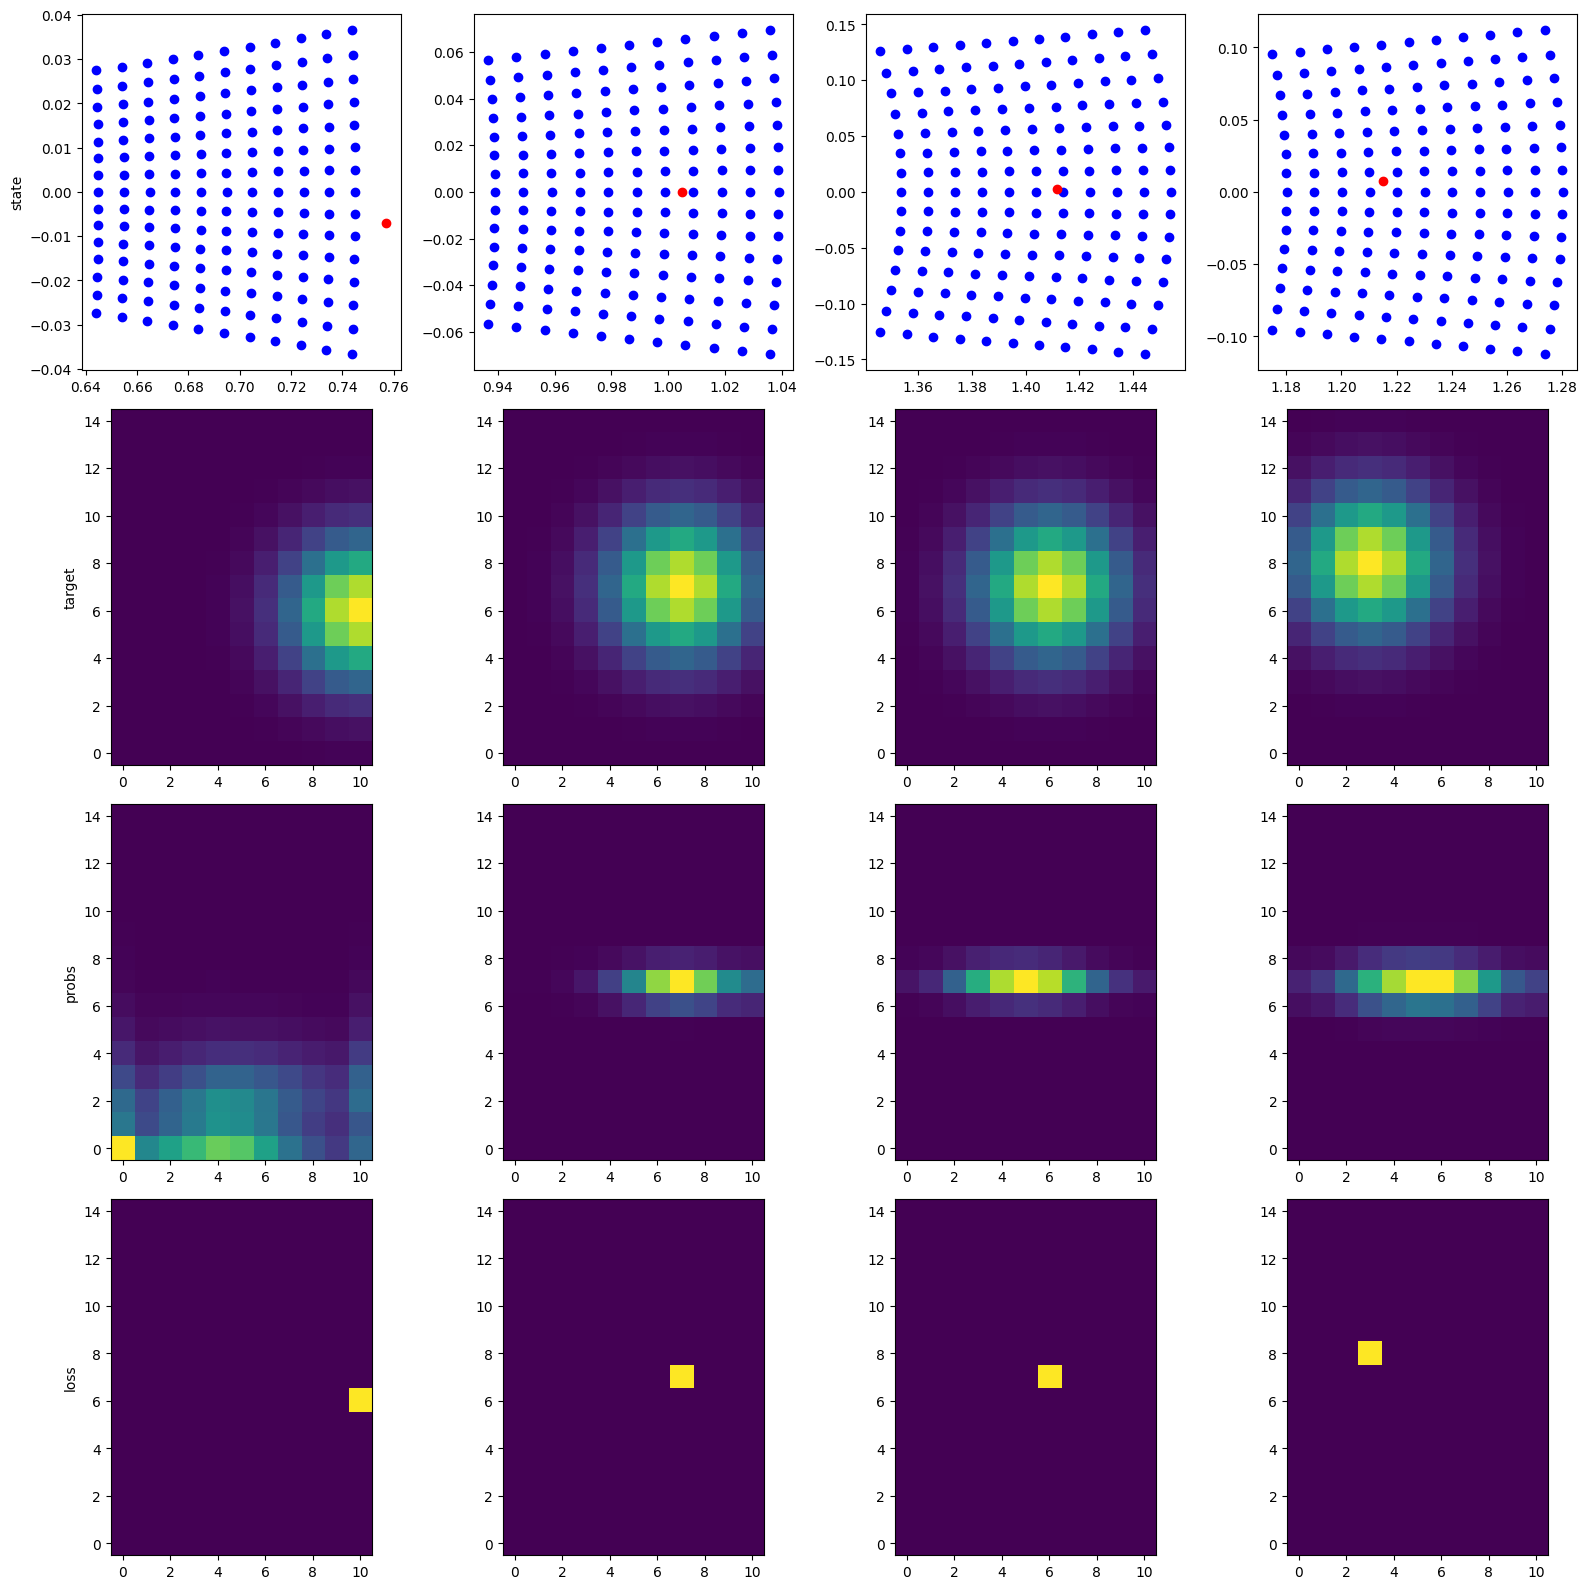

In [19]:
n_rows = 4
fig, axes = plt.subplots(n_rows, n_center_objs, figsize=(4*n_center_objs, 4*n_rows))

for i in range(n_rows):
    if i == 0:
        title = 'state'
    elif i == 1:
        title = 'target'
        plots = targets
    elif i == 2:
        title = 'probs'
        plots = pred_probs
    else:
        title = 'loss'
        plots = loss_all

    for j in range(n_center_objs):
        ax = axes[i, j]
        if i == 0:
            ax.scatter(state_nxt[j, :, 0], state_nxt[j, :, 1], c='b')
            ax.scatter(center_gt[j, 0], center_gt[j, 1], c='r')
        elif i == 1 or i == 2:
            # ax.imshow(plots[j].T, vmin=0, vmax=1)
            ax.imshow(plots[j].T)
            ax.invert_yaxis()
            # if i == 1:
            #     print(np.max(plots[j]))
            # else:
            #     print(np.sum(plots[j]))
        else:
            print(np.max(plots[j]), np.min(plots[j]))
            ax.imshow(plots[j].T)
            ax.invert_yaxis()
        if j == 0:
            ax.set_ylabel(title)
plt.tight_layout()

# fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# for i, ax in enumerate(axes.flat):
#     ax.imshow(pred_probs[i].T)
#     # ax.imshow(loss_all[i].T)
#     # print(np.max(loss_all[i]))
#     ax.invert_yaxis()
